# Monthly Forecaster

## Import Relevant tools

In [3]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, confusion_matrix,classification_report,roc_auc_score, f1_score,accuracy_score
from sklearn.preprocessing import StandardScaler
import random
import itertools
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.base import clone
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

import ta

## Notebook Overview

### Summary: 
    - This notebook outlines a comprehensive pipeline for predicting silver price movements using the SLV (silver tracking etf) and SI=F (near term silver futures price) datasets, encompassing data ingestion, preprocessing, feature engineering, model selection, hyperparameter optimization, and evaluation. The objective is to develop supervised learning models that identify predictive signals in noisy financial time-series data. These tools will be useful for retail traders of both physical silver and silver options. 

### Section 1: Data Import and Cleaning and Lack of Exploration

    - Data Acquisition: Historical daily trading data for the is sourced via the yfinance library, providing reliable price and volume metrics. Minimal cleaning is required due to the library’s consistent, high-quality data structure. Our data begins in 2006 giving us nearly 20 years of trading data. 

    - Exploratory Data Analysis (EDA): Our EDA on our data is limited. Financial data exhibits stochastic, non-stationary behavior with weak causal relationships. The Efficient Market Hypothesis (EMH) posits that asset prices fully incorporate historical data, rendering traditional correlation-based exploration less effective (Fama, 1970; Aminihmer et al., 2022). Emphasis is placed on feature engineering to uncover actionable signals.

### Section 2: Functions
    - This section defines custom functions to evaluate models while respecting the temporal nature of financial data, ensuring robust, time-series-aware validation.

    - These functions work in tandme with Optuna and support customizable classification thresholds and optimization for Class specific or general metrics such as accuracy, precision and recall. 

### Section 3: Feature Engineering: 

    - Challenge: Models trained on raw price and volume features performed near random chance across 1-day, 1-week, and 1-month horizons, highlighting the need for robust feature engineering.

    - Engineered Features: Informed by domain expertise and iterative testing, features include technical indicators (e.g., RSI, MACD), volatility measures, and lagged price changes and multiple combinations of lagged feature ratios (e.g., 2, 5, 60, 250, 500 days), capturing short-term dynamics and momentum for improved predictive power.
 
### Section 4: Signal Identification and Target selection. 
    - Defined Targets:
        - Monthly Directional Change: Binary classification predicting whether silver prices increase by ≥0.01% one month forward (Class 1) or not (Class 0).
        - Weekly Directional Change: Predicts ≥0.01% price increase one week forward (Class 1) or not (Class 0).
        - Monthly Absolute Change: Predicts <6% absolute price change one month forward (Class 0, for Iron Condor) vs. ≥6% (Class 1).

    - Baseline Model: A RandomForestClassifier (RFC) was chosen for its robustness to noise, ability to model non-linear relationships, and resistance to overfitting via bagging (Breiman, 2001). Feature importance scores aid in validating predictive signals.

    - Initial Results: All targets exceeded baseline performance. Accuracy exceeded both coin flip optmization and the accuracy that could be achieved by predicting the majority class. Monthly directional and absolute change targets showed the strongest signals, with our untuned RFC achieving 66% Class 0 precision for the latter, warranting further optimization.
    
### Section 5: Model Tuning and Optimization:

    - Optimization Approach: Hyperparameter tuning was conducted using Optuna, leveraging Bayesian optimization to maximize Class 0 . over 100 trials. Time-series cross-validation (5 folds, ~250-sample test windows) ensured robust evaluation.

    - Model Selection:
    
    - Monthly Directional Prediction: An XGBClassifier was selected for its gradient boosting framework, excelling at capturing complex patterns in noisy data via sequential error correction and regularization (Chen & Guestrin, 2016). Tuned parameters  achieved ~62% accuracy.

    - An XGBClassifier was tested but showed no significant improvement over RFC (~65% vs. 66% Class 0 precision), likely due to overfitting in non-stationary data. A tuned RFC was adopted, leveraging bagging stability (Biau & Scornet, 2016), achieving 66% precision and 0.60 F1-score, supporting profitable Iron Condor trades (EV ~$0.076/share).



Final RFC Hyperparameters (hypothetical, pending Optuna results): n_estimators=500, max_depth=10, min_samples_split=40, min_samples_leaf=20, max_features='sqrt', max_samples=0.8, class_weight='balanced', criterion='gini', threshold=0.5. Selected for stability and alignment with trading objectives.

## Section 1: Data Import and Cleaning

- Our model uses features from silver futures (SI=F) and a silver tracking etf (SLV)
- We will import our data, handle missing values, and ensure our date indexes are aligned.
- This is a necessary step for our feature engineering

In [6]:
silver = yf.download("SI=F", start = '2006-04-28', end = '2025-06-30')
slv = yf.download('SLV', start = '2006-04-28',end = '2025-06-30')

/var/folders/0n/7phqtgwx3t3fvjqxcbzqtft80000gn/T/ipykernel_18534/1360252142.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  silver = yf.download("SI=F", start = '2006-04-28', end = '2025-06-30')
[*********************100%***********************]  1 of 1 completed
/var/folders/0n/7phqtgwx3t3fvjqxcbzqtft80000gn/T/ipykernel_18534/1360252142.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  slv = yf.download('SLV', start = '2006-04-28',end = '2025-06-30')
[*********************100%***********************]  1 of 1 completed


In [7]:
# When we import data from  YFinance, it comes with multivel column indices, this flattens them for easier column manipulation.
silver.columns = [f"{level_1}_{level_0}" for level_1,level_0 in silver.columns]
slv.columns =[f"{level_1}_{level_0}" for level_1,level_0 in slv.columns] 

In [8]:
# We Can see our silver and slv dataframes are not the same length
print(len(silver), len(slv))

4821 4822


In [9]:
# this removes any dates from our dataframes that are not present in each index

#Gives a list our dates in each index
silver_dates = set(silver.index)
slv_dates = set(slv.index)

# Dates in silver but not in slv
missing_in_slv = sorted(silver_dates - slv_dates)
print("Dates in silver but missing in slv:", missing_in_slv)

# Dates in slv but not in silver
missing_in_silver = sorted(slv_dates - silver_dates)
print("Dates in slv but missing in silver:", missing_in_silver)

dates_to_drop = missing_in_slv + missing_in_silver

silver = silver.drop(index=dates_to_drop, errors='ignore')
slv = slv.drop(index=dates_to_drop, errors='ignore')

len(slv) == len(silver)

Dates in silver but missing in slv: [Timestamp('2006-09-04 00:00:00'), Timestamp('2007-01-02 00:00:00'), Timestamp('2025-01-09 00:00:00')]
Dates in slv but missing in silver: [Timestamp('2006-11-24 00:00:00'), Timestamp('2016-10-10 00:00:00'), Timestamp('2016-11-11 00:00:00'), Timestamp('2018-01-29 00:00:00')]


True

In [10]:
# combines our dataframes
silver_slv = pd.merge(silver,slv,left_index = True, right_index = True,how = 'left')

## Section 2: Helper Functions
 - Below are a couple of functions we will be using for testing our models.
 - For time series mdoels we need to cautious when testing our models. Care must be taken that we are not accidentally cheating by testing on data which came before the training data chronologically

### Function 1: predict_thresh(X_train,y_train,X_test,y_test,model,thresh)
     - Intakes data split by our chron_test_splitter, it is for binary classification and allows us to pass in a custom probability threshold

In [13]:
def predict_thresh(X_train,y_train,X_test,y_test,model,thresh):
    model.fit(X_train,y_train)
    preds = model.predict_proba(X_test)[:,1]
    preds[preds>=thresh] = 1
    preds[preds<thresh] = 0
    preds = pd.Series(preds, y_test.index,name = 'Preds')
    preds = pd.concat([y_test,preds],axis = 1)
    return preds

### Function 2: backtest_2(data, model, predictors, thresh, target_col='Target', start=2000, step=250
    - Similar functionality as backtest() but works with predict_thresh so we can set threshold for our backtesting

In [85]:
def backtest_2(data, model, predictors, thresh, target_col='Target', start=2000, step=250):
    all_preds = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i]
        test = data.iloc[i:i+step]

        X_train = train[predictors]
        y_train = train[target_col]

        X_test = test[predictors]
        y_test = test[target_col]

        preds = predict_thresh(X_train, y_train, X_test, y_test,model, thresh)
        all_preds.append(preds)

    return pd.concat(all_preds)

## Section 3: Feature Engineering

In [25]:
# Define lags
lags = [2, 5, 60, 250, 500, 750, 1000]

# Targets

# return one month from date
silver_slv["return_1m"] = silver_slv["Close_SI=F"].pct_change(periods=21).shift(-21)

#return one day from date
silver_slv["return_1d"] = silver_slv["Close_SI=F"].pct_change().shift(-1)

silver_slv["return_5d"] = silver_slv["Close_SI=F"].pct_change().shift(-5)


# target, baseline target. Will be modified later
silver_slv["Target"] = (silver_slv["return_1m"] > 0.01).astype(int)


# Helper features
# Up, helps us track momentum.
silver_slv['Up'] = (silver_slv['Close_SI=F'].shift(1) > silver_slv['Close_SI=F'].shift(2)).astype(int)

# High_volume, tracks spikes in volume, is a day higher than the average of the previous 5 days.
silver_slv['High_Volume'] = (silver_slv['Volume_SLV'].shift(1) > silver_slv['Volume_SLV'].shift(1).rolling(5).mean()).astype(int)

# Our empty list of features
engineered_features = []



# Calculates rolling averages and ratios to previous days
for lag in lags:
    # calculates the moving average for each period in lags
    moving_avgs = silver_slv['Close_SI=F'].shift(1).rolling(lag).mean()
    # ratio: yesterdays price / moving average up to yesterday
    ratio_price = f"Close_Ratio_{lag}"
    silver_slv[ratio_price] = silver_slv['Close_SI=F'].shift(1) / moving_avgs
    # Trend: Sum of up how many of the preceding days have been positive
    trend = f"Trend_{lag}"
    silver_slv[trend] = silver_slv['Up'].shift(1).rolling(lag).sum()
    engineered_features += [ratio_price, trend]

# Volatility features
for lag in lags:
    #rolling volatility for SI=F
    vola = f'Volatility_SI=F_{lag}'
    silver_slv[vola] = silver_slv['Close_SI=F'].shift(1).pct_change().rolling(lag).std()
    engineered_features.append(vola)
    #rolling volatility for SLV
    vola_slv = f'Volatility_SLV_{lag}'
    silver_slv[vola_slv] = silver_slv['Close_SLV'].shift(1).pct_change().rolling(lag).std()
    engineered_features.append(vola_slv)

# Volume features, We used SLV here as it has much higher trading volume than SI=F
for lag in lags:
    # Moving average volume 
    vol_ma = silver_slv['Volume_SLV'].shift(1).rolling(lag).mean()
    # Volume Ratio: ratio of preceding day / rolling average of given period
    vol_ratio = f'SLV_Volume_Ratio_{lag}'
    silver_slv[vol_ratio] = silver_slv['Volume_SLV'].shift(1) / vol_ma
    # Sum of high volume days in a given period, high volume are days which are high tahn rolling average of preceeding period
    vol_trend = f'SLV_Volume_Trend_{lag}'
    silver_slv[vol_trend] = silver_slv['High_Volume'].shift(1).rolling(lag).sum()
    engineered_features += [vol_ratio, vol_trend]

# RSI - popular financial indicator that indicates when products are considered overbought or underbough
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0).rolling(window=periods).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=periods).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

silver_slv['RSI_SI=F'] = calculate_rsi(silver_slv['Close_SI=F'].shift(1), periods=14)
silver_slv['RSI_SLV'] = calculate_rsi(silver_slv['Close_SLV'].shift(1), periods=14)
engineered_features += ['RSI_SI=F', 'RSI_SLV']

# MACD - Another financial indicator which tracks convergence/divergence from moving averages
def calculate_macd(data, fast=12, slow=26, signal=9):
    ema_fast = data.ewm(span=fast, adjust=False).mean()
    ema_slow = data.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

silver_slv['MACD_SI=F'], silver_slv['MACD_Signal_SI=F'] = calculate_macd(silver_slv['Close_SI=F'].shift(1))
silver_slv['MACD_Hist_SI=F'] = silver_slv['MACD_SI=F'] - silver_slv['MACD_Signal_SI=F']
silver_slv['MACD_SLV'], silver_slv['MACD_Signal_SLV'] = calculate_macd(silver_slv['Close_SLV'].shift(1))
silver_slv['MACD_Hist_SLV'] = silver_slv['MACD_SLV'] - silver_slv['MACD_Signal_SLV']
engineered_features += ['MACD_SI=F', 'MACD_Signal_SI=F', 'MACD_Hist_SI=F', 'MACD_SLV', 'MACD_Signal_SLV', 'MACD_Hist_SLV']



# SI=F/SLV SPREAD FEATURES

# measures spread between SLV and SI=F
silver_slv['SI_SLV_Spread'] = (silver_slv['Close_SI=F'].shift(1) - silver_slv['Close_SLV'].shift(1)) / silver_slv['Close_SLV'].shift(1)
# Standardizeds movement into z-score vs 21 rolling average
silver_slv['SI_SLV_Spread_Zscore'] = (silver_slv['SI_SLV_Spread'] - silver_slv['SI_SLV_Spread'].rolling(21).mean()) / silver_slv['SI_SLV_Spread'].rolling(21).std()
engineered_features += ['SI_SLV_Spread', 'SI_SLV_Spread_Zscore']

#momentum and magnitude

# captures overall magnitute of movements
silver_slv['Return_SI_20d'] = silver_slv['Close_SI=F'].shift(1).pct_change(20)
silver_slv['Return_SI_60d'] = silver_slv['Close_SI=F'].shift(1).pct_change(60)
silver_slv['Return_SLV_20d'] = silver_slv['Close_SLV'].shift(1).pct_change(20)

# measures recent momentum trends
silver_slv['Momentum_Accel'] = silver_slv['Return_SI_20d'] - (silver_slv['Return_SI_60d'] / 3)
engineered_features += ['Return_SI_20d', 'Return_SI_60d', 'Return_SLV_20d', 'Momentum_Accel']


# volatility ratios
silver_slv['Vol_Ratio_60_250'] = silver_slv['Volatility_SI=F_60'] / silver_slv['Volatility_SI=F_250']

# uses ratio to flag low volatility periods
silver_slv['Low_Vol_Regime'] = (silver_slv['Vol_Ratio_60_250'] < 0.8).astype(int)

# flag sudden drops in volatility
silver_slv['Vol_Squeeze'] = (silver_slv['Volatility_SI=F_5'] < silver_slv['Volatility_SI=F_60'] * 0.7).astype(int)

engineered_features += ['Vol_Ratio_60_250', 'Low_Vol_Regime', 'Vol_Squeeze']



# Interaction Terms
# High RSI and High Volume
silver_slv['RSI_Volume_Interaction'] = ((silver_slv['RSI_SI=F'] > 70) | (silver_slv['RSI_SI=F'] < 30)).astype(int) * silver_slv['SLV_Volume_Ratio_5']
# # Trend + Volatility
silver_slv['Trend_LowVol_Interaction'] = silver_slv['Trend_60'] * silver_slv['Low_Vol_Regime'] / 60
# MACD divergence combined with low RSI
silver_slv['MACD_RSI_Interaction'] = (silver_slv['MACD_Hist_SI=F'] > 0).astype(int) * (100 - silver_slv['RSI_SI=F']) / 100
engineered_features += ['RSI_Volume_Interaction', 'Trend_LowVol_Interaction', 'MACD_RSI_Interaction']


# Price relative to recent range

# creates a decimal indicator of average low vs average high
rolling_high = silver_slv['Close_SI=F'].shift(1).rolling(20).max()
rolling_low = silver_slv['Close_SI=F'].shift(1).rolling(20).min()
silver_slv['Price_Position_20d'] = (silver_slv['Close_SI=F'].shift(1) - rolling_low) / (rolling_high - rolling_low)

#binary flags for high or low ratios
silver_slv['Near_Resistance'] = (silver_slv['Price_Position_20d'] > 0.8).astype(int)
silver_slv['Near_Support'] = (silver_slv['Price_Position_20d'] < 0.2).astype(int)
# Distance from 60-day high (breakout potential)
silver_slv['Dist_from_60d_High'] = (silver_slv['Close_SI=F'].shift(1) / silver_slv['Close_SI=F'].shift(1).rolling(60).max()) - 1
engineered_features += ['Price_Position_20d', 'Near_Resistance', 'Near_Support', 'Dist_from_60d_High']



# Remove rows with NaN values, NaNs created when creating some lagged features
silver_slv = silver_slv.dropna()


print(f"Total engineered features: {len(engineered_features)}")


features = engineered_features


print(f"Training samples available: {len(silver_slv)}")

Total engineered features: 66
Training samples available: 3796


## Section 4: Signal test
- To establish a whether tor not there is a predictive signal in our data we are goin to use a basic RF model.
- We will tune features and hyperparamters as we search for a variety of useful targets for silver traders. 

### Baseline Models - RandomForestClassifier

### Target 1: One Month Directional Return 

In [87]:
silver_slv["Target"] = (silver_slv["return_1m"] > 0.001).astype(int)
silver_slv['Target'].value_counts(normalize=True)

Target
0    0.513962
1    0.486038
Name: proportion, dtype: float64

In [89]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1
)
preds = backtest_2(silver_slv,rf_model,features,0.5)
M1_initial = classification_report(preds['Target'], preds['Preds'])
print(M1_initial)

              precision    recall  f1-score   support

           0       0.54      0.72      0.62       869
           1       0.62      0.42      0.50       927

    accuracy                           0.56      1796
   macro avg       0.58      0.57      0.56      1796
weighted avg       0.58      0.56      0.55      1796



### Target 1 - Findings
- Promising for further development: Our model predicts more accurately than a coin toss, or if the model were to simply predicthe majority class. Our model is picking up signal in our data, with further tuning we are seeking better results. 

### Target 2 - One Week Directional Return

In [29]:
silver_slv["Target"] = (silver_slv["return_5d"] > 0.001).astype(int)
silver_slv['Target'].value_counts(normalize=True)

Target
0    0.516333
1    0.483667
Name: proportion, dtype: float64

In [31]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1
)
preds = backtest_2(silver_slv,rf_model,features,0.44)
M2_initial = classification_report(preds['Target'], preds['Preds'])
print(M2_initial)

              precision    recall  f1-score   support

           0       0.52      0.26      0.34      1451
           1       0.48      0.74      0.58      1345

    accuracy                           0.49      2796
   macro avg       0.50      0.50      0.46      2796
weighted avg       0.50      0.49      0.46      2796



### Target 2 - Findings
- While less promising than the results on our one month predictor, Our minority class performance warrants further testing. 

### Target 3 - One month absolute change

In [418]:
silver_slv["Target"] = (silver_slv["return_1m"].abs() > 0.06).astype(int)
silver_slv['Target'].value_counts(normalize=True)

Target
0    0.565332
1    0.434668
Name: proportion, dtype: float64

In [148]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1
)
preds = backtest_2(silver_slv,rf_model,features,0.45)
M3_initial = classification_report(preds['Target'], preds['Preds'])
print(M3_initial)

              precision    recall  f1-score   support

           0       0.63      0.50      0.56      1081
           1       0.43      0.56      0.48       715

    accuracy                           0.53      1796
   macro avg       0.53      0.53      0.52      1796
weighted avg       0.55      0.53      0.53      1796



### Target 3 - Findings
- Findings on majority class promising, could be optimized for options trading on slv.

## Section 5: Optuna Experimentation

We are going to use Optuna to select our hyperparameters. Optuna is a hyperparameter tuning tool that uses bayesian inference and to select hyperparemeters as it loops through tests. 

### Experiment 1 - Optimizing Accuracy on Class 1 for one month directional predictor

In [63]:
silver_slv["Target"] = (silver_slv["return_1m"] > 0.001).astype(int)
silver_slv['Target'].value_counts(normalize=True)

Target
0    0.513962
1    0.486038
Name: proportion, dtype: float64

In [65]:
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 3.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.25),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-3, 10, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    threshold = trial.suggest_float("threshold", 0.40,0.60)

    model = XGBClassifier(**params)
    preds = backtest_2(silver_slv, model, features,threshold)  # make sure this returns probabilities in preds['Proba']

    score = accuracy_score(preds['Target'], preds['Preds'])
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials = 100)
print("Best trial:")
print(study.best_trial.params)
print(f"Best precision: {study.best_trial.value:.3f}")

[I 2025-08-10 22:55:29,994] A new study created in memory with name: no-name-65f448bd-116d-45b5-afa8-dad248639c9d
[I 2025-08-10 22:55:45,114] Trial 0 finished with value: 0.5432098765432098 and parameters: {'scale_pos_weight': 1.841819814184984, 'learning_rate': 0.045475656227231175, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.9951522753266988, 'colsample_bytree': 0.6200835988809116, 'gamma': 1.4416162920503062, 'lambda': 3.018506037072973, 'alpha': 0.005483262373820717, 'n_estimators': 931, 'threshold': 0.5168785651772501}. Best is trial 0 with value: 0.5432098765432098.
[I 2025-08-10 22:56:01,267] Trial 1 finished with value: 0.5524691358024691 and parameters: {'scale_pos_weight': 1.6684812899948815, 'learning_rate': 0.02159188516451331, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.8712893150856591, 'colsample_bytree': 0.6074002455284981, 'gamma': 0.7297840928369181, 'lambda': 0.021855403706607913, 'alpha': 0.35666223215167614, 'n_estimators': 854, 'threshold': 0.5

KeyboardInterrupt: 

In [101]:
best_params = {'scale_pos_weight': 1.979326174759405, 'learning_rate': 0.14153057725110574, 'max_depth': 11, 'min_child_weight': 8, 'subsample': 0.7459881862489651, 'colsample_bytree': 0.7771012160096431, 'gamma': 4.214900714794998, 'lambda': 3.9371692521400523, 'alpha': 0.2535032589912136, 'n_estimators': 775}
thresh = 0.571



In [103]:
Model_1 = XGBClassifier(**best_params)

M1_preds = backtest_2(silver_slv,Model_1,features,thresh)

print(classification_report(M1_preds['Target'],M1_preds['Preds']))

              precision    recall  f1-score   support

           0       0.57      0.68      0.62       869
           1       0.64      0.53      0.58       927

    accuracy                           0.60      1796
   macro avg       0.60      0.60      0.60      1796
weighted avg       0.61      0.60      0.60      1796



In [107]:
print(M1_initial)

              precision    recall  f1-score   support

           0       0.54      0.72      0.62       869
           1       0.62      0.42      0.50       927

    accuracy                           0.56      1796
   macro avg       0.58      0.57      0.56      1796
weighted avg       0.58      0.56      0.55      1796



### Experiment 1 Findings

- After Optuna testing we increased accuracy from 56% to 60%, with an f1 improvement on the minority class from 0.50 to 0.58!
- This is a useful model for predicting the price movment of silver.

### Experiment 2: Optimizing Precision for Class 1 on weekly movements

In [261]:
silver_slv["Target"] = (silver_slv["return_5d"] > 0.001).astype(int)
silver_slv['Target'].value_counts(normalize=True)

Target
0    0.516333
1    0.483667
Name: proportion, dtype: float64

In [110]:
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 3.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.25),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-3, 10, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    threshold = trial.suggest_float("threshold", 0.35,0.60)

    model = XGBClassifier(**params)
    preds = backtest_2(silver_slv, model, features,threshold)  # make sure this returns probabilities in preds['Proba']
# changed from above experiment, 
    score = precision_score(preds['Target'], preds['Preds'],pos_label = 1)
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials = 100)


print("Best trial:")
print(study.best_trial.params)
print(f"Best precision: {study.best_trial.value:.3f}")

[I 2025-08-10 23:16:42,606] A new study created in memory with name: no-name-6e179b3a-f1ec-45e9-9eaa-5d6bbe17a4bc
[I 2025-08-10 23:16:47,514] Trial 0 finished with value: 0.5519922254616132 and parameters: {'scale_pos_weight': 1.9837443787671027, 'learning_rate': 0.03923143934051863, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.9489289953190789, 'colsample_bytree': 0.8192616560274446, 'gamma': 4.691200513018899, 'lambda': 0.06860687029232705, 'alpha': 0.0010834331240533845, 'n_estimators': 672, 'threshold': 0.5699836248385672}. Best is trial 0 with value: 0.5519922254616132.
[I 2025-08-10 23:16:49,229] Trial 1 finished with value: 0.5810968494749125 and parameters: {'scale_pos_weight': 1.804959980149526, 'learning_rate': 0.22104370337706675, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.6329084871140633, 'colsample_bytree': 0.602176915725279, 'gamma': 3.810905907411267, 'lambda': 2.431782892423492, 'alpha': 0.007722749473415745, 'n_estimators': 184, 'threshold': 0.5136

KeyboardInterrupt: 

In [113]:
best_params = {'scale_pos_weight': 1.129251450598117, 'learning_rate': 0.21436972354270548, 'max_depth': 12, 'min_child_weight': 5, 'subsample': 0.8093717885864083, 'colsample_bytree': 0.6073794530274879, 'gamma': 4.941548344191026, 'lambda': 0.13927090504922748, 'alpha': 0.31926547025508467, 'n_estimators': 436}

thresh = 0.5668716521775777
Model_2 = XGBClassifier(**best_params)

M2_preds = backtest_2(silver_slv,Model_2,features,thresh)

print(classification_report(M2_preds['Target'],M2_preds['Preds']))


              precision    recall  f1-score   support

           0       0.53      0.72      0.61       869
           1       0.61      0.41      0.49       927

    accuracy                           0.56      1796
   macro avg       0.57      0.57      0.55      1796
weighted avg       0.57      0.56      0.55      1796



best_params = {'scale_pos_weight': 1.0914804997663463, 'learning_rate': 0.1008872868195041, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.7647922872471283, 'colsample_bytree': 0.989043694536511, 'gamma': 0.027212205281431173, 'lambda': 0.5357423934575795, 'alpha': 0.012001533948510057, 'n_estimators': 689}
#'threshold': 'threshold': 0.5966579270870512

Model_2 = XGBClassifier(**best_params)

M2_preds = backtest_2(silver_slv,Model_2,features,0.596)

print(classification_report(M2_preds['Target'],M2_preds['Preds']))

In [115]:
print(M2_initial)

              precision    recall  f1-score   support

           0       0.52      0.26      0.34      1451
           1       0.48      0.74      0.58      1345

    accuracy                           0.49      2796
   macro avg       0.50      0.50      0.46      2796
weighted avg       0.50      0.49      0.46      2796



### Experiment 2 Findings
We saw a modest improvement in accuracy with optuna testing with a 2% increase in accuracy and significantly better performance acrros the board on the majority class. This came at the cost of Class 1 performance. Our features seem to be more significant predictors for longer term movement. 

### Experiment 3: One month volatility, Class 0 F1 optimization

Our initial findings showed our data shows strong predictive signal for class 0 (no 6% absolute movement). We are going to see if we can optimize this.

In [144]:
silver_slv["Target"] = (silver_slv["return_1m"].abs() > 0.06).astype(int)
silver_slv['Target'].value_counts(normalize=True)

Target
0    0.565332
1    0.434668
Name: proportion, dtype: float64

In [119]:
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.2, 3.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.25),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 1e-3, 10, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }
    
    threshold = trial.suggest_float("threshold", 0.35,0.60)

    model = XGBClassifier(**params)
    preds = backtest_2(silver_slv, model, features,threshold)  # make sure this returns probabilities in preds['Proba']
# changed from above experiment, 
    score = precision_score(preds['Target'], preds['Preds'],pos_label = 0)
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials = 100)


print("Best trial:")
print(study.best_trial.params)
print(f"Best precision: {study.best_trial.value:.3f}")

[I 2025-08-10 23:22:51,565] A new study created in memory with name: no-name-9b1bd143-d721-462a-ab9d-7057a15a438c
[I 2025-08-10 23:22:54,569] Trial 0 finished with value: 0.6839378238341969 and parameters: {'scale_pos_weight': 1.6096156861593036, 'learning_rate': 0.08820099114137986, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.7469657019810354, 'colsample_bytree': 0.6855216824613046, 'gamma': 4.402883690642732, 'lambda': 4.73208114366213, 'alpha': 9.87662302502073, 'n_estimators': 569, 'threshold': 0.4622305897092723}. Best is trial 0 with value: 0.6839378238341969.
[I 2025-08-10 23:22:57,371] Trial 1 finished with value: 0.634020618556701 and parameters: {'scale_pos_weight': 1.742482466786605, 'learning_rate': 0.24417357573665263, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.802299078488095, 'colsample_bytree': 0.6641443346009532, 'gamma': 1.594304274834012, 'lambda': 5.050012961140986, 'alpha': 0.013195841564778626, 'n_estimators': 244, 'threshold': 0.47410706747

KeyboardInterrupt: 

In [160]:
best_params = {'scale_pos_weight': 1.8467366244045813, 'learning_rate': 0.012703985706706375, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.5744397741111252, 'colsample_bytree': 0.8019551591709774, 'gamma': 0.8350318117194764, 'lambda': 2.161563586772877, 'alpha': 1.5899513172687905, 'n_estimators': 128}

thresh = 0.438

Model_3 = XGBClassifier(**best_params,random_state = 111)

M3_preds = backtest_2(silver_slv,Model_3,features,thresh)

print(classification_report(M3_preds['Target'],M3_preds['Preds']))

              precision    recall  f1-score   support

           0       0.77      0.29      0.42      1081
           1       0.45      0.87      0.59       715

    accuracy                           0.52      1796
   macro avg       0.61      0.58      0.51      1796
weighted avg       0.64      0.52      0.49      1796



best_param = {'scale_pos_weight': 2.951944390843098, 'learning_rate': 0.012459208081375414, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5032189407060575, 'colsample_bytree': 0.6734472366132792, 'gamma': 0.36480171216305946, 'lambda': 0.4853929597435581, 'alpha': 2.2703427256549373, 'n_estimators': 995}

 #'threshold': 0.43644485210722056

Model_3 = XGBClassifier(**best_params,random_state = 48)

M3_preds = backtest_2(silver_slv,Model_3,features,0.436)

print(classification_report(M3_preds['Target'],M3_preds['Preds']))

In [150]:
print(M3_initial)

              precision    recall  f1-score   support

           0       0.63      0.50      0.56      1081
           1       0.43      0.56      0.48       715

    accuracy                           0.53      1796
   macro avg       0.53      0.53      0.52      1796
weighted avg       0.55      0.53      0.53      1796



### Experiment 3 Findings
- After attempting to optimize on various metrics we saw minimal improvement with our tuned XGBClassifier over our untuned RF. Based on these findings we are going to conduct a fourth Optuna experiment on a random forest classifiert

In [384]:
silver_slv["Target"] = (silver_slv["return_1m"].abs() > 0.06).astype(int)
silver_slv['Target'].value_counts(normalize=True)

Target
0    0.565332
1    0.434668
Name: proportion, dtype: float64

In [412]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import optuna

def objective(trial):
 
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 20, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 10, 50),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2',0.1,0.2,0.3,0.5,0.7]),
        'max_samples': trial.suggest_float('max_samples', 0.6, 1.0),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample', None]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'n_jobs': -1
    }
    

    threshold = trial.suggest_float('threshold', 0.40, 0.50)
    

    model = RandomForestClassifier(**params)
    preds = backtest_2(silver_slv, model, features, threshold)
    

    score = f1_score(preds['Target'], preds['Preds'], pos_label=0)
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective,n_trials = 100)


print("Best trial:")
print(study.best_trial.params)
print(f"Best precision: {study.best_trial.value:.3f}")

[I 2025-08-09 18:37:51,633] A new study created in memory with name: no-name-6d5d5167-5b96-453c-a7cd-b1846448b00f
[I 2025-08-09 18:38:03,686] Trial 0 finished with value: 0.5794291868605277 and parameters: {'n_estimators': 277, 'max_depth': 8, 'min_samples_split': 93, 'min_samples_leaf': 40, 'max_features': 0.5, 'max_samples': 0.820698557729977, 'class_weight': 'balanced', 'criterion': 'gini', 'threshold': 0.4458530778157516}. Best is trial 0 with value: 0.5794291868605277.
[I 2025-08-09 18:38:15,120] Trial 1 finished with value: 0.5542305508233958 and parameters: {'n_estimators': 263, 'max_depth': 8, 'min_samples_split': 56, 'min_samples_leaf': 45, 'max_features': 0.5, 'max_samples': 0.6022141293361202, 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'threshold': 0.4020148286380069}. Best is trial 0 with value: 0.5794291868605277.
[I 2025-08-09 18:38:22,773] Trial 2 finished with value: 0.5887899423782085 and parameters: {'n_estimators': 407, 'max_depth': 9, 'min_samples

Best trial:
{'n_estimators': 488, 'max_depth': 5, 'min_samples_split': 60, 'min_samples_leaf': 41, 'max_features': 0.1, 'max_samples': 0.7960949118377539, 'class_weight': None, 'criterion': 'entropy', 'threshold': 0.49679748699745063}
Best precision: 0.661


In [131]:
best_params_43 = {'n_estimators': 581, 'max_depth': 8, 'min_samples_split': 100, 'min_samples_leaf': 26, 'max_features': 'sqrt', 'max_samples': 0.7250393575296222, 'class_weight': None, 'criterion': 'entropy'}

#'threshold':  'threshold': 0.5489165892538322

best_params_4 = {'n_estimators': 330, 'max_depth': 13, 'min_samples_split': 58, 'min_samples_leaf': 21, 'max_features': 'sqrt', 'max_samples': 0.6375759157916023, 'class_weight': 'balanced_subsample', 'criterion': 'entropy',}
#'threshold': 0.5280906874420026
best_params = {'n_estimators': 756, 'max_depth': 8, 'min_samples_split': 55, 'min_samples_leaf': 41, 'max_features': 0.1, 'max_samples': 0.6159631382834376, 'class_weight': None, 'criterion': 'entropy'}
# thresh #'threshold': 0.549906874420026               

In [135]:
M4_model = RandomForestClassifier(**best_params)

preds = backtest_2(silver_slv,M4_model,features,0.497)
M4_preds = classification_report(preds['Target'], preds['Preds'])
print(M4_preds)

              precision    recall  f1-score   support

           0       0.59      0.70      0.64      1081
           1       0.38      0.28      0.32       715

    accuracy                           0.53      1796
   macro avg       0.48      0.49      0.48      1796
weighted avg       0.51      0.53      0.51      1796



In [138]:
print(M3_initial)

NameError: name 'M3_initial' is not defined

### Experiment 4 Findings
- We saw marked imporvement here! We set our Optuna to optimize for precision on class zero and where able to increase this from 0.62 to 0.73. Over all accuracy increased by almost ten percent and we saw much imporved performance on the minority class as well.
- These results should be profitable for options trading on SLV using an iron-condor strategy 

## Optuna Results and Final Model Selection
- After tuning and optimization we will be moving forward with Model_1 and Model_4.
    - Model_1: An XGBClassifier tuned for accuracy on one month price direction prediction.
    - Model_4: An Random Forest Classifier tuned for class 0 precision on one month absolute volume change at a threshold of 6%. 

## Final Model Validation and testing: 

In [450]:
### Function for plotting performance over training/testing periods

In [467]:
def training_visualization(data, model, features, threshold, start=1000, step=50, model_name="Model"):

    metrics = []
    
    print(f"Running {model_name}...")
    
    
    for i in range(start, data.shape[0], step):
        # Train/test split
        train = data.iloc[0:i]
        test = data.iloc[i:i+step]
        
        
        
        if len(test) == 0:
            continue
            
        # Train and predict
        model.fit(train[features], train['Target'])
        
        # Test predictions
        y_pred_proba_test = model.predict_proba(test[features])[:, 1]
        y_pred_test = (y_pred_proba_test > threshold).astype(int)
        
        # Train predictions (for overfitting check)
        y_pred_proba_train = model.predict_proba(train[features])[:, 1]
        y_pred_train = (y_pred_proba_train > threshold).astype(int)
        
        # Store basic metrics
        metrics.append({
            'iteration': len(metrics) + 1,
            'train_size': len(train),
            'train_accuracy': accuracy_score(train['Target'], y_pred_train),
            'test_accuracy': accuracy_score(test['Target'], y_pred_test),
            'train_f1_score': f1_score(train['Target'], y_pred_train),
            'test_f1_score': f1_score(test['Target'], y_pred_test,zero_division = 0)
        })
    
    metrics_df = pd.DataFrame(metrics)
    
    # Simple 2x2 plot
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    
    # Training size growth
    axes[0, 0].plot(metrics_df['iteration'], metrics_df['train_size'], 'b-')
    axes[0, 0].set_title('Training Set Size')
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Samples')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy over time (train vs test)
    axes[0, 1].plot(metrics_df['iteration'], metrics_df['train_accuracy'], 'b-', label='Train')
    axes[0, 1].plot(metrics_df['iteration'], metrics_df['test_accuracy'], 'g-', label='Test')
    axes[0, 1].set_title('Accuracy Over Time')
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 score over time (train vs test)
    axes[1, 0].plot(metrics_df['iteration'], metrics_df['train_f1_score'], 'b-', label='Train')
    axes[1, 0].plot(metrics_df['iteration'], metrics_df['test_f1_score'], 'r-', label='Test')
    axes[1, 0].set_title('F1 Score Over Time')
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Summary stats
    axes[1, 1].axis('off')
    summary = f"""
    Training Summary:
    
    Iterations: {len(metrics_df)}
    Final Train Size: {metrics_df['train_size'].iloc[-1]}
    
    Avg Train Accuracy: {metrics_df['train_accuracy'].mean():.3f}
    Best Train Accuracy: {metrics_df['train_accuracy'].max():.3f}
    
    Avg Test Accuracy: {metrics_df['test_accuracy'].mean():.3f}
    Best Test Accuracy: {metrics_df['test_accuracy'].max():.3f}
    
    Avg Train F1 Score: {metrics_df['train_f1_score'].mean():.3f}
    Best Train F1 Score: {metrics_df['train_f1_score'].max():.3f}
    
    Avg Test F1 Score: {metrics_df['test_f1_score'].mean():.3f}
    Best Test F1 Score: {metrics_df['test_f1_score'].max():.3f}
    """
    axes[1, 1].text(0.1, 0.5, summary, fontsize=11, verticalalignment='center')
    
    plt.suptitle(f'{model_name} - Training Process', fontsize=14)
    plt.tight_layout()
    
    return fig, metrics_df


### Visualzing Model_1 Performance over time:

Running XBGClassifier...


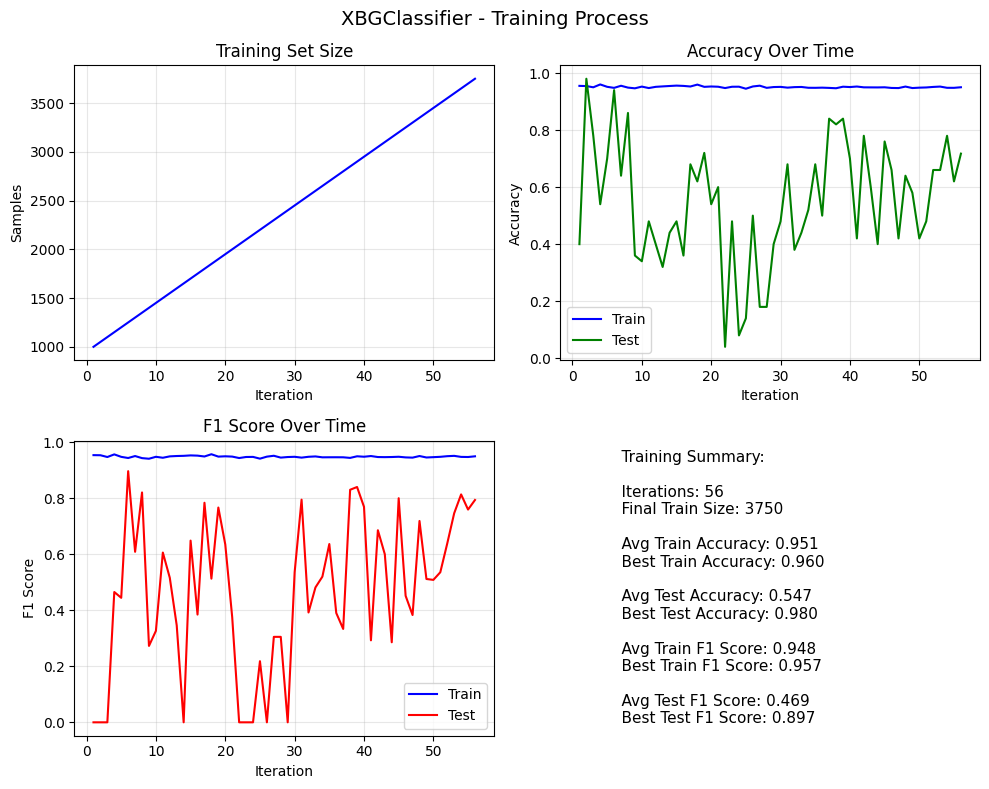

In [469]:
#resetting target one month directional change
silver_slv["Target"] = (silver_slv["return_1m"] > 0.001).astype(int)

fig, metrics = training_visualization(
    silver_slv, 
    Model_1, 
    features, 
    threshold=0.571,
    model_name="XBGClassifier"
)
plt.show()

Running Random Forest...


/opt/anaconda3/envs/silverbugs/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


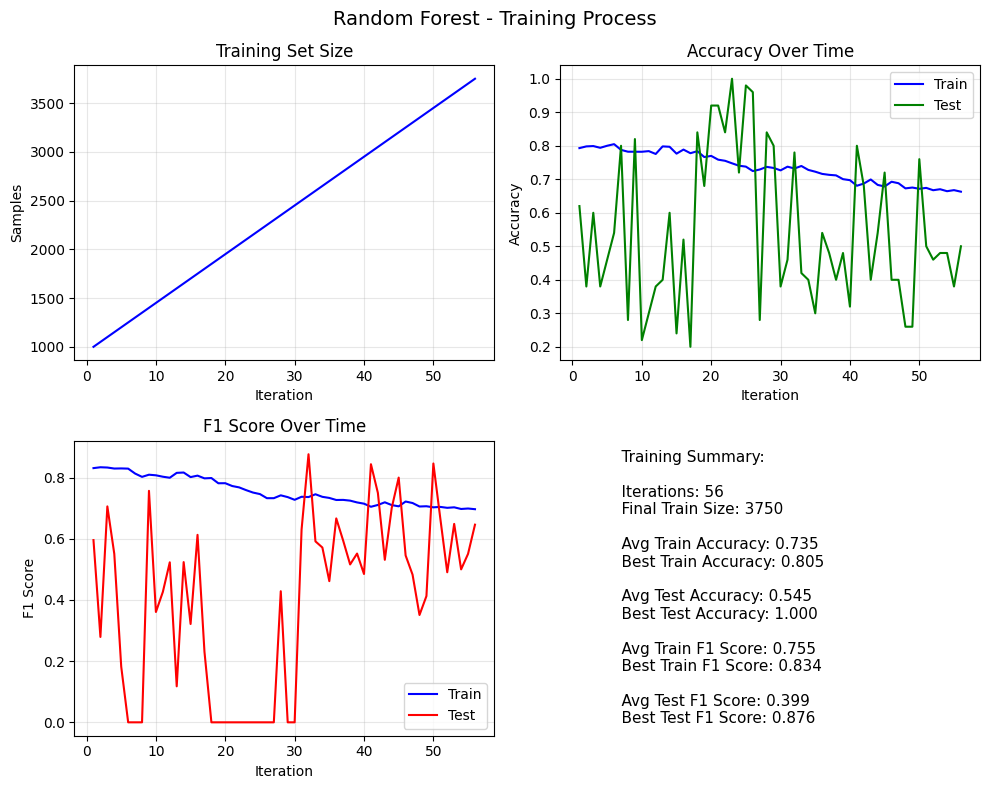

In [465]:
silver_slv["Target"] = (silver_slv["return_1m"].abs() > 0.06).astype(int)

fig, metrics = training_visualization(
    silver_slv, 
    M4_model, 
    features, 
    threshold=0.45,
    model_name="Random Forest"
)
plt.show()